# Train transformer

In [11]:
import torch

from transformer_implementation import Transformer, Tokenizer, TransformerConfig, DataLoaderFactory
from utils import training_loop, plot_losses, estimate_loss

## Init
### Tokenizer

In [2]:
# init tokenizer
tokenizer = Tokenizer()

### Config

In [3]:
# init config
config = TransformerConfig(tokenizer, max_iters = 5, eval_interval = 4, device = 'cpu')
print(config)

TransformerConfig(
	self.tokenizer=<transformer_implementation.Tokenizer.Tokenizer object at 0x0000027AA1F6C690>,
	self.block_size=256,
	self.batch_size=12,
	self.n_layer=2,
	self.n_head=4,
	self.n_embd=256,
	self.dropout=0.1,
	self.bias=False,
	self.device='cpu',
	self.learning_rate=0.0003,
	self.max_iters=5,
	self.eval_interval=4,
	self.eval_iters=20,
	self.visualize=False,
)


### Loading dataset

In [4]:
# loading dataset
dataset = DataLoaderFactory(config.block_size, config.batch_size, tokenizer, config.device)
len(dataset)

Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


Number of data by datasets splits
Train		: 5000000	-> 416666.6666666667
Validation	: 3000		-> 250.0
Test		: 3003		-> 250.25
Total		: 5006003


5006003

### Model

In [5]:
# Create model
model = Transformer(config)
model.train()
model = model.to(config.device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.98), eps=1e-9)

Number of Encoder parameters: 27.25M
number of parameters: 27.77M


## Training

### Loop

In [6]:
losses_list = training_loop(model, optimizer, dataset, config, saved_path = "./out/transformer-train.pth")

Train loss nan, Val loss nan, Saved nan:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/20 [00:00<?, ?it/s]

### Plotting losses

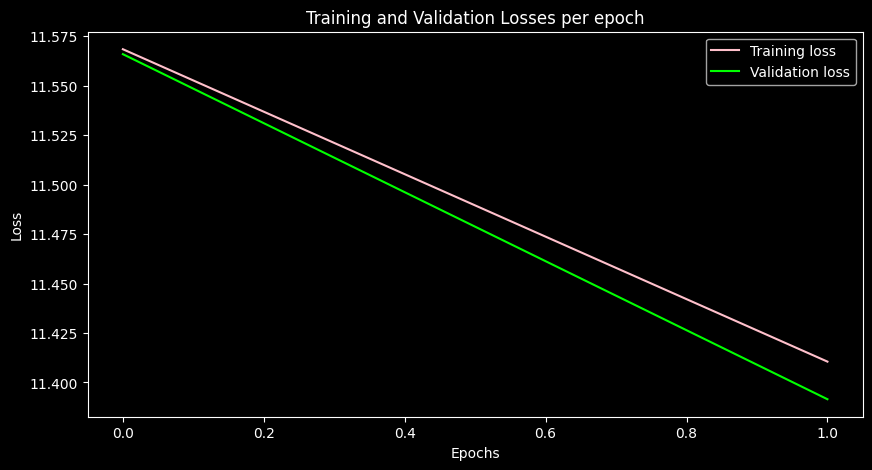

In [7]:
# Call the function
plot_losses(losses_list)

## Testing

In [12]:
test_loss = estimate_loss(model, dataset, config, ['test'])

Evaluation - test:   0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
print(f"Test loss = {test_loss['test'].item():4f}")

Test loss = 11.337641
